# Store item demand forecasting

### load the dataset

In [119]:
import pandas as pd
import numpy as np 

In [120]:
train = pd.read_csv('train_demand.csv', parse_dates=['date'])

In [121]:
train['date'].head() # take a look at the datetime column

0   2013-01-01
1   2013-01-02
2   2013-01-03
3   2013-01-04
4   2013-01-05
Name: date, dtype: datetime64[ns]

In [122]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [123]:
train.drop(['item', 'store'], axis=1, inplace=True)

In [124]:
train.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [125]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


### the time range of the train dataset

In [126]:
print(f"the minimal date of the train dataset is: {train['date'].min().date()}")
print("the maximal date of the train dataset is: {}".format(train['date'].max().date()))

the minimal date of the train dataset is: 2013-01-01
the maximal date of the train dataset is: 2017-12-31


### see if there is missing values

In [127]:
train.isnull().sum() # no missing values

date     0
sales    0
dtype: int64

### train_test_split

In [128]:
train.value_counts().sort_values()[-20:].head() # as we can see, on some dates, there are multiple sales records, we will need to aggregate those values

date        sales
2013-12-30  25       22
2013-01-08  27       22
2013-01-28  31       22
2014-02-03  30       22
2013-12-23  14       22
dtype: int64

In [129]:
Xtrain = train[train['date']<='2016']
Xtest = train[train['date']>='2017']

In [130]:
Xtrain = Xtrain.sort_values('date').groupby('date').mean()['sales']

In [131]:
Xtest = Xtest.sort_values('date').groupby('date').mean()['sales']

In [132]:
print(f'the train dataset is {len(Xtrain)} in length')
print(f'the test dataset is {len(Xtest)} in length')

the train dataset is 1096 in length
the test dataset is 365 in length


### visualize the data with interactive plots

In [133]:
pip install cufflinks

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [134]:
import matplotlib.pyplot as plt

In [135]:
import cufflinks as cf
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [136]:
cf.go_offline()

In [137]:
Xtrain.iplot() # one simple way to plot a interactive plot

In [138]:
# if you want more detail
fig = make_subplots()
fig.add_trace(go.Scatter(x=Xtrain.index, y=Xtrain))
fig.update_layout(autosize=True, height=500, width=900, title_text='Sales')
fig.update_xaxes(title_text='year')
fig.update_yaxes(title_text='prices')

In [139]:
# now we plot the train and test dataset together
fig = make_subplots()
fig.add_trace(go.Scatter(x = Xtrain.index, y = Xtrain, name='Train set'))
fig.add_trace(go.Scatter(x = Xtest.index, y = Xtest, name='Test set'))
fig.update_layout(height=500, width=1000, autosize=True, title_text='Sales')
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Prices')

### scaler the dataset

In [140]:
from sklearn.preprocessing import MinMaxScaler

In [141]:
scaler = MinMaxScaler(feature_range=(0,1))
Xtrain = scaler.fit_transform(Xtrain.values.reshape(-1,1))
Xtrain.shape

(1096, 1)

In [142]:
Xtest = scaler.fit_transform(Xtest.values.reshape(-1,1))
Xtest.shape

(365, 1)

### reshape the dataset into a time-seris appropriate problem

In [143]:
def reshape_data(data, day_past, day_future):
    x = []
    y = []
    for i in range(len(data)):
        end = i+day_past
        end_plus = end+day_future
        if end_plus>len(data):
            break
        past = data[i:end]
        future = data[end:end_plus]
        x.append(past)
        y.append(future)
    return np.array(x), np.array(y)

In [144]:
day_past=30
day_future = 5
xtrain, ytrain = reshape_data(Xtrain, day_past, day_future)

In [145]:
xtrain.shape

(1062, 30, 1)

In [146]:
ytrain.shape

(1062, 5, 1)

In [163]:
xtest, ytest = reshape_data(Xtest, day_past, day_future)

In [148]:
xtest.shape

(331, 30, 1)

In [149]:
ytest.shape

(331, 5, 1)

In [150]:
# The LSTM model expects the input to have shape: (Samples, Timesteps, Number of feautures). 

### create the model 

In [151]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint

In [152]:
model = models.Sequential()
model.add(layers.LSTM(100, activation='relu', input_shape=(day_past, 1)))
model.add(layers.Dropout(0.2))
model.add(layers.RepeatVector(day_future))
model.add(layers.LSTM(100, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.TimeDistributed(layers.Dense(1, activation='linear')))

model.compile(optimizer='adam',loss= 'mean_squared_error', metrics=['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 100)               40800     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 repeat_vector_5 (RepeatVect  (None, 5, 100)           0         
 or)                                                             
                                                                 
 lstm_12 (LSTM)              (None, 5, 100)            80400     
                                                                 
 dropout_12 (Dropout)        (None, 5, 100)            0         
                                                                 
 time_distributed_4 (TimeDis  (None, 5, 1)             101       
 tributed)                                            

In [153]:
check = ModelCheckpoint(filepath= './check.hdf5', verbose=0, save_best_only=True)
model.fit(xtrain,ytrain, verbose=0, epochs=50, callbacks=[check])

In [154]:
model.history.history.keys()

dict_keys(['loss', 'acc'])

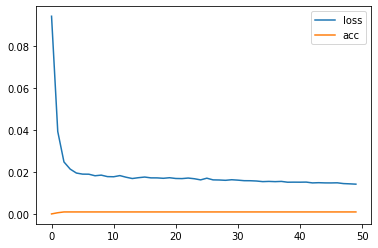

In [155]:
plt.plot(range(50), model.history.history['loss'], label='loss')
plt.plot(range(50), model.history.history['acc'], label='acc')
plt.legend();

### predict sales

In [156]:
predicted_sales = model.predict(xtest)

11/11 [==============================] - 0s 6ms/step


In [157]:
predicted_sales.shape

(331, 5, 1)

In [158]:
ytest = scaler.inverse_transform(np.squeeze(ytest))
predicted_sales = scaler.inverse_transform(np.squeeze(predicted_sales))

In [159]:
ytest = ytest.flatten()
predicted_sales = predicted_sales.flatten()

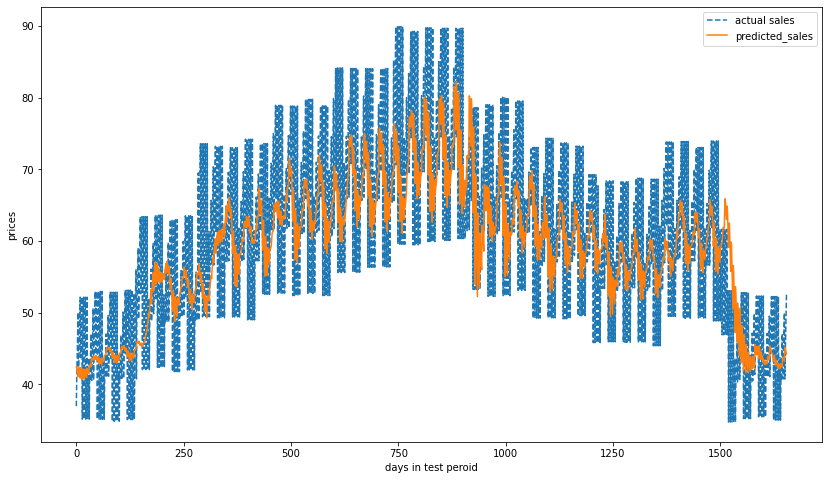

In [160]:
plt.plot(ytest, label='actual sales', linestyle='--')
plt.plot(predicted_sales, label='predicted_sales')
plt.legend()
plt.xlabel('days in test peroid')
plt.ylabel('prices')
fig = plt.gcf()
fig.set_size_inches(14,8) 